In [1]:
# Requires 0.24
import os
import sys
sys.path.insert(1,os.path.abspath('../0. Not_git/Sources/scikit-learn/0.24.0'))
import sklearn
print(sklearn.__version__)
#this will be 0.24.2 

0.24.0


### Import libraries

In [2]:
# Modules
import numpy as np
import math
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

# Metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Autoregressor
from skforecast.ForecasterAutoreg import ForecasterAutoreg

# Hyperparameter Grid search
from skforecast.model_selection import grid_search_forecaster

# Backtesting
from skforecast.model_selection import backtesting_forecaster

# Models
from sklearn.ensemble import ExtraTreesRegressor
from xgboost import XGBRegressor 
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor

import plotly.io as pio

In [3]:
# Enable to render plotly graphs into GitHub
pio.renderers.default = "svg"

In [4]:
# Select country in analysis ('FIN', 'DEN', 'NOR', 'SWE')
country = 'DEN'

# True to include exogenous features
exogenous_features = True

# Dependant variable 
dep_var = 'TIV'

### Load Data

In [5]:
# Input path and filename
path = '../5. Master_thesis/Datasets/Output_files/'

# Load files into a pandas dataframes
if exogenous_features:
    file = path + '0.xlsx'  # Use file 0 if you want to work with original data withou feature eng/sel
else:
    file = path + 'target.xlsx'
    
df = pd.read_excel(file, sheet_name=country)

# Set index
df = df.set_index("Date").asfreq('MS')

In [6]:
df

,Orders,CPI,UR,LTIR,TIV
Date,,,,,
2006-01-01,161,2.184466,4.1,3.311,65.640787
2006-02-01,250,2.163461,4.2,3.484,61.924395
2006-03-01,468,1.911589,4.2,3.704,83.479473
2006-04-01,412,1.902497,4.2,3.975,77.672609
2006-05-01,550,2.021403,4.1,4.022,91.928459
...,...,...,...,...,...
2022-08-01,343,8.909952,4.5,1.375,74.473027
2022-09-01,337,10.018900,4.6,2.200,75.796992
2022-10-01,322,10.112360,4.6,2.599,63.242553


In [7]:
# Create copies of the original dataframe
df_diff = df.copy()

In [8]:
df_diff[dep_var + '_diff'] = df_diff[dep_var].diff(1)
df_diff.drop([dep_var], axis=1, inplace=True)
df_diff = df_diff.rename(columns={dep_var + '_diff': dep_var})    
df_diff.dropna(inplace=True)

In [9]:
df_diff

,Orders,CPI,UR,LTIR,TIV
Date,,,,,
2006-02-01,250,2.163461,4.2,3.484,-3.716393
2006-03-01,468,1.911589,4.2,3.704,21.555078
2006-04-01,412,1.902497,4.2,3.975,-5.806864
2006-05-01,550,2.021403,4.1,4.022,14.255850
2006-06-01,441,2.137767,4.0,4.029,7.316648
...,...,...,...,...,...
2022-08-01,343,8.909952,4.5,1.375,16.892167
2022-09-01,337,10.018900,4.6,2.200,1.323965
2022-10-01,322,10.112360,4.6,2.599,-12.554439


In [10]:
df = df_diff

In [11]:
# Function to revert back differences
def diff_inv(series_diff, first_value):
    # Cumsum serie starting from first value
    series_inverted = np.r_[first_value,series_diff].cumsum()
    # Delete first element 
    new_array = np.delete(series_inverted, [0])   
    return new_array

### Split Data

In [12]:
# Split data
steps = 36  # Number of months of testing
train = df[:-steps]
test  = df[-steps:]

print(f"Dataset length : (n={len(df)})")
print(f"Train dates    : {train.index.min()} --- {train.index.max()}  (n={len(train)})")
print(f"Test dates     : {test.index.min()} --- {test.index.max()}  (n={len(test)})")

start = train.index.min()
end = df.index.max()
start_test = test.index.min()

start, end, start_test

# Define exogenous variables
df_exo = df[df.columns.difference([dep_var])]
train_exo = train[train.columns.difference([dep_var])]
test_exo = test[test.columns.difference([dep_var])]

print('\nData shape:', train.shape, test.shape)
print('Exog shape:', train_exo.shape, test_exo.shape)

# Save previous value to inverse transform
#previous_value = df_original.iloc[-steps-1].Orders
#df_original = df_original.iloc[1:]


Dataset length : (n=203)
Train dates    : 2006-02-01 00:00:00 --- 2019-12-01 00:00:00  (n=167)
Test dates     : 2020-01-01 00:00:00 --- 2022-12-01 00:00:00  (n=36)

Data shape: (167, 5) (36, 5)
Exog shape: (167, 4) (36, 4)


### Scoring function

In [13]:
metrics = pd.DataFrame()

def scoring(model_name, y_true, y_pred, print_metrics: bool, plot_results: bool):

    # Calculate metrics
    mae = mean_absolute_error(y_true, y_pred)                      # MAE (Mean Absolute Error)
    mse = mean_squared_error(y_true, y_pred)                       # MSE (Mean Squared Error)
    rmse = math.sqrt(mse)                                          # RMSE (Root Mean Squared Error)
    r2 = r2_score(y_true, y_pred)                                  # R2 (R-squared - Coeficient of determination)                           
    mape = np.mean(np.abs((y_true - y_pred) /y_true)) * 100        # MAPE
    accuracy = 100 - mape                                          # Accuracy

    # Append metrics for summary
    metrics[model_name] = [mae, mse, rmse, r2, mape, accuracy]
    metrics.index = ['Mean Absolute Error', 
                    'Mean Squared Error', 
                    'Root Mean Squared Error',
                    'R^2',
                    'Mean Absolute Percentage Error',
                    'Accuracy']

    # Print metrics  
    if print_metrics:
 
        print(model_name, 'Model Performance:')                             # Model name
        print('Mean Absolute Error: {:0.2f}.'.format(mae))                  # MAE
        print('Mean Squared Error: {:0.2f}.'.format(mse))                   # MSE
        print('Root Mean Squared Error: {:0.2f}.'.format(rmse))             # RMSE  
        print('R^2 Score = {:0.2f}.'.format(r2))                            # R2
        print('Mean Absolute Percentage Error: {:0.2f}%.'.format(mape))     # MAPE 
        print('Accuracy = {:0.2f}%.'.format(accuracy))                      # Accuracy
        
    # Plot Actual values vs predicted values
    if plot_results:
        
        df = pd.DataFrame(y_true)

        fig= make_subplots(rows=2, cols=1)
        
        fig.add_trace(go.Scatter(dict(x=df.index, y=y_true, mode='lines', name= 'Actual'), legendgroup="Preds"), row=1, col=1)
        fig.add_trace(go.Scatter(dict(x=df.index, y=y_pred, mode='lines', name= 'Predicted'), legendgroup="Preds"), row=1, col=1)
                
        fig.add_trace(go.Scatter(dict(x=train.index, y=train[dep_var], mode='lines', name= 'Train'), legendgroup="Full"), row=2, col=1)
        fig.add_trace(go.Scatter(dict(x=test.index, y=y_true, mode='lines', name= 'Test'), legendgroup="Full"), row=2, col=1)
        fig.add_trace(go.Scatter(dict(x=test.index, y=y_pred, mode='lines', name= 'Forecast'), legendgroup="Full"), row=2, col=1)

        fig.update_layout(height=600, width=1000, title_text=model_name + " Predictions in " + country)    

        fig.show()         

### Models

Extra Tree Model Performance:
Mean Absolute Error: 21.49.
Mean Squared Error: 789.93.
Root Mean Squared Error: 28.11.
R^2 Score = -0.06.
Mean Absolute Percentage Error: 185.72%.
Accuracy = -85.72%.


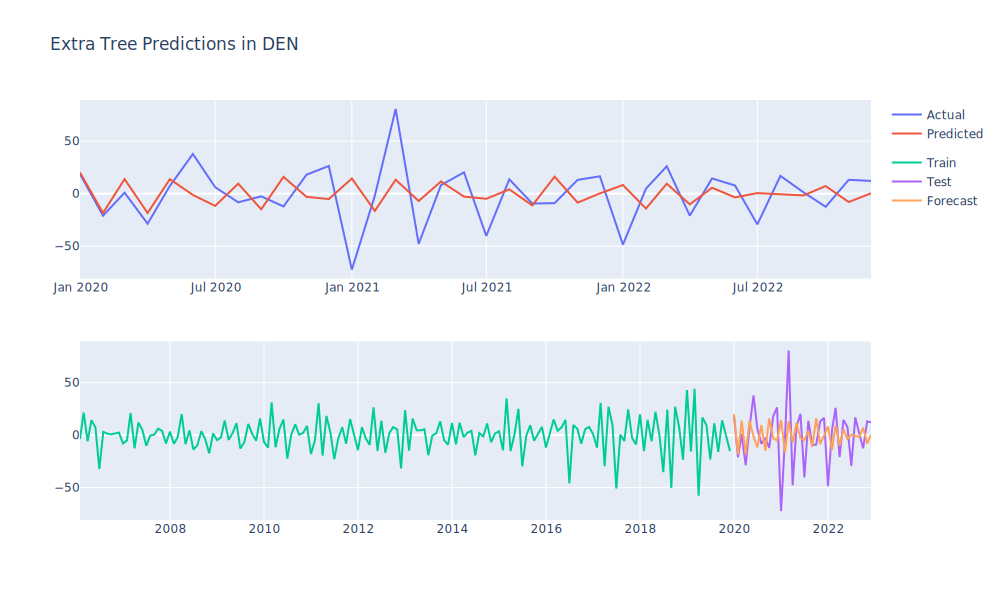

XGBoost Model Performance:
Mean Absolute Error: 22.85.
Mean Squared Error: 900.85.
Root Mean Squared Error: 30.01.
R^2 Score = -0.21.
Mean Absolute Percentage Error: 275.38%.
Accuracy = -175.38%.


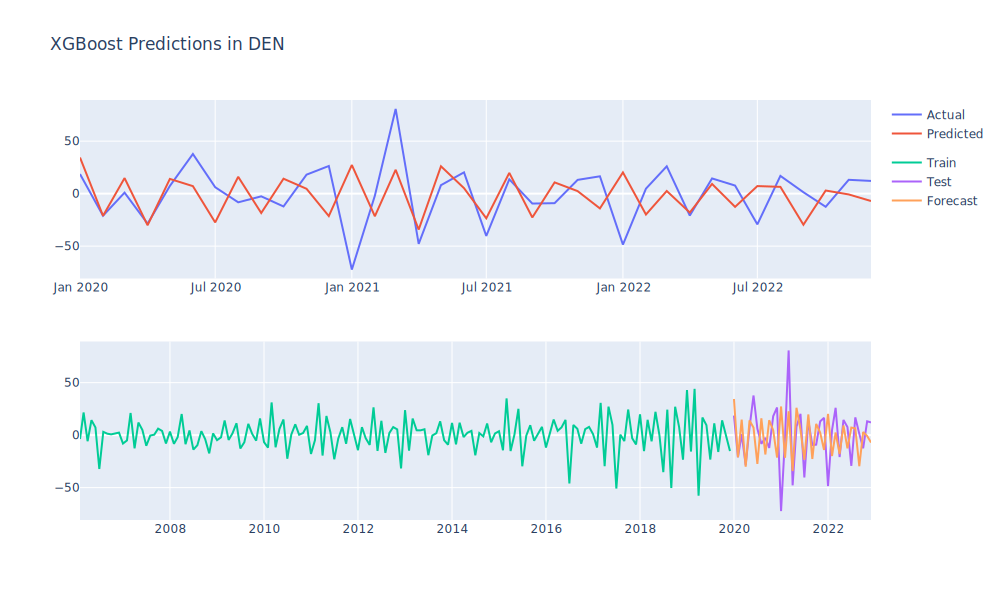

Gradient Boosting Model Performance:
Mean Absolute Error: 22.99.
Mean Squared Error: 873.76.
Root Mean Squared Error: 29.56.
R^2 Score = -0.18.
Mean Absolute Percentage Error: 239.85%.
Accuracy = -139.85%.


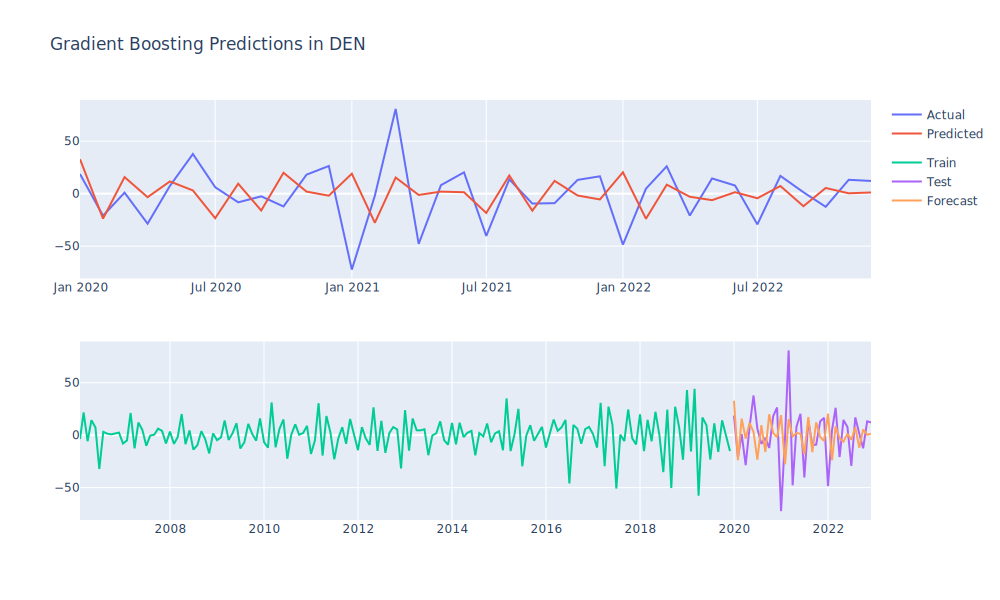

Random Forest Model Performance:
Mean Absolute Error: 22.99.
Mean Squared Error: 871.14.
Root Mean Squared Error: 29.52.
R^2 Score = -0.17.
Mean Absolute Percentage Error: 243.80%.
Accuracy = -143.80%.


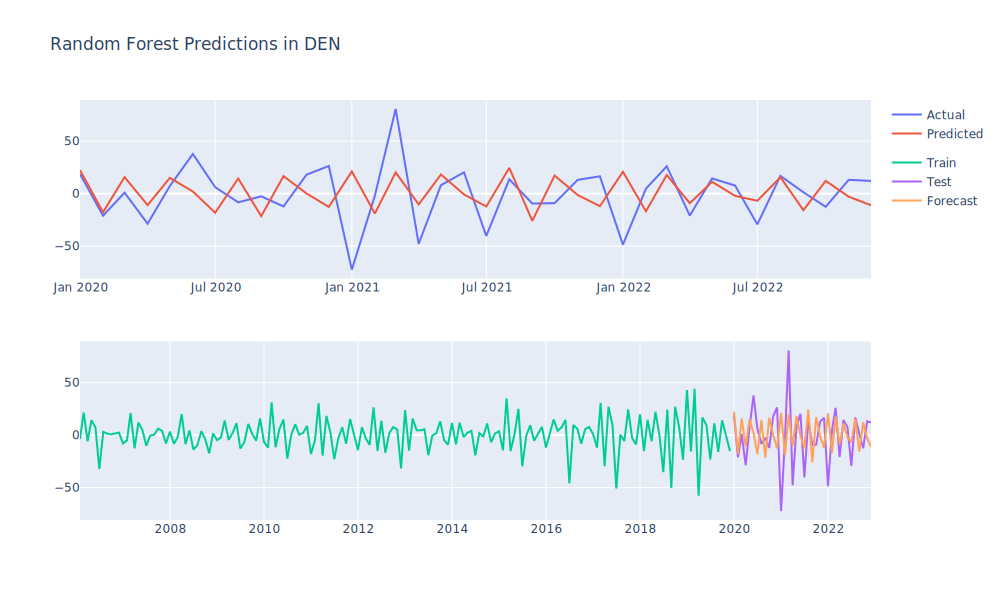

Ada Boost Model Performance:
Mean Absolute Error: 22.68.
Mean Squared Error: 837.49.
Root Mean Squared Error: 28.94.
R^2 Score = -0.13.
Mean Absolute Percentage Error: 279.62%.
Accuracy = -179.62%.


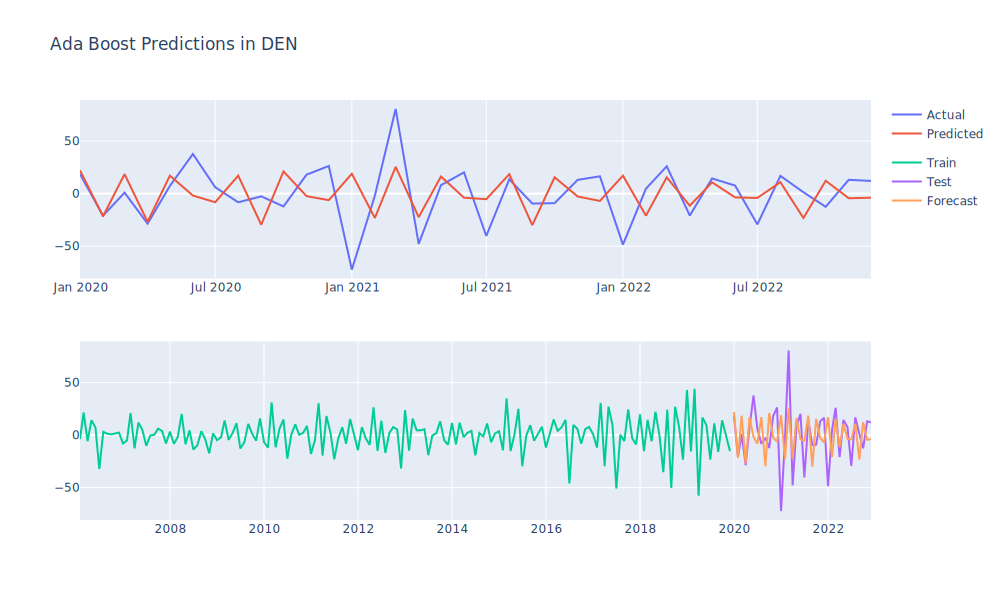

LightGBM Model Performance:
Mean Absolute Error: 24.12.
Mean Squared Error: 960.70.
Root Mean Squared Error: 31.00.
R^2 Score = -0.30.
Mean Absolute Percentage Error: 313.03%.
Accuracy = -213.03%.


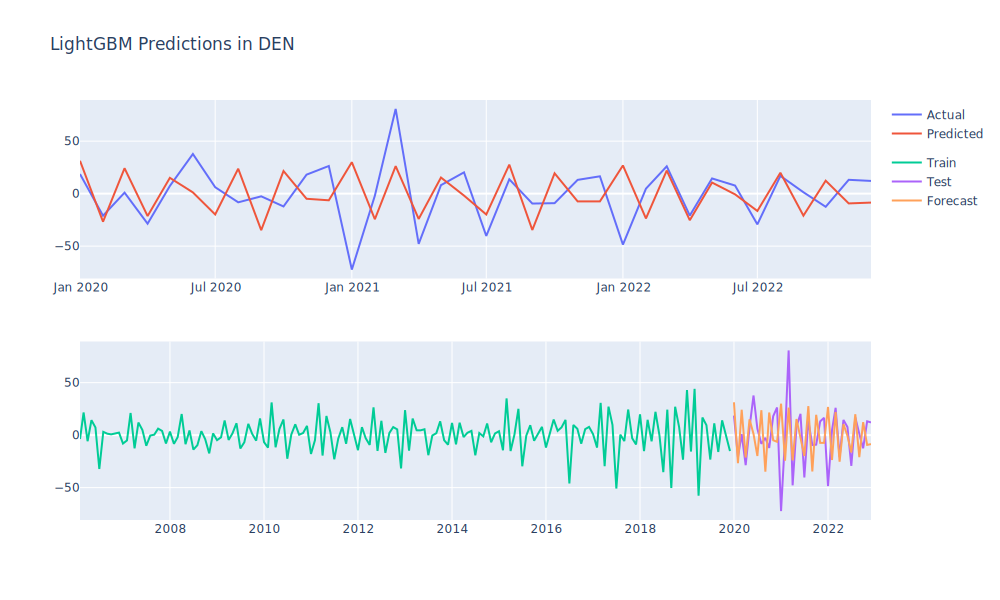

Decision Tree Model Performance:
Mean Absolute Error: 26.64.
Mean Squared Error: 1217.34.
Root Mean Squared Error: 34.89.
R^2 Score = -0.64.
Mean Absolute Percentage Error: 316.21%.
Accuracy = -216.21%.


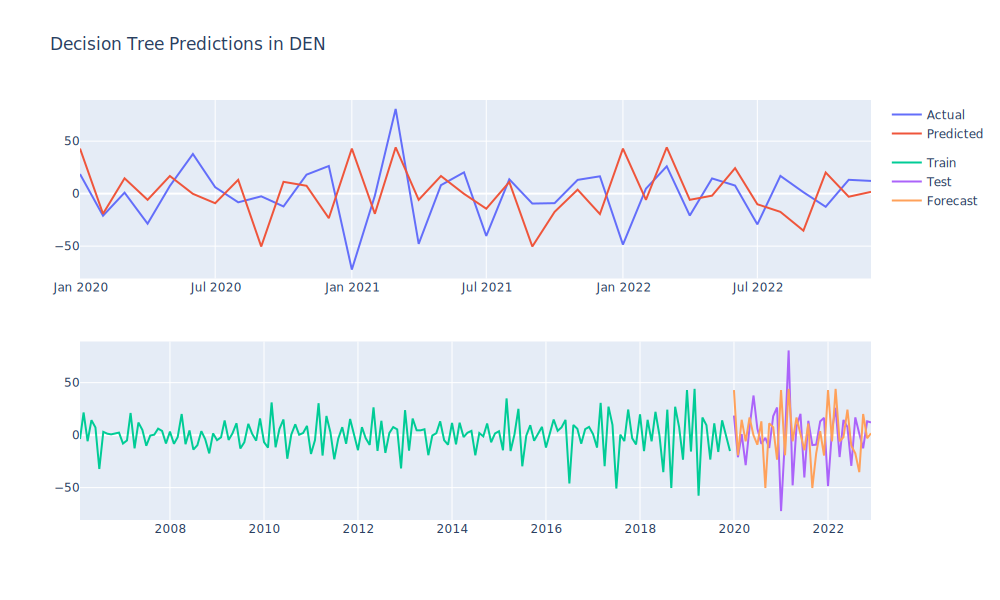

In [14]:
modelclasses = [
    ["Extra Tree", ExtraTreesRegressor],
    ["XGBoost", XGBRegressor],
    ["Gradient Boosting", GradientBoostingRegressor],
    ["Random Forest", RandomForestRegressor],
    ["Ada Boost", AdaBoostRegressor],
    ["LightGBM", LGBMRegressor],
    ["Decision Tree", DecisionTreeRegressor]
]

number_of_lags = 12

for model_name, Model in modelclasses:            
        
    # Create forecaster
    forecaster = ForecasterAutoreg(
            regressor = Model(),
            lags = number_of_lags
    )
    
    # Fit model
    forecaster.fit(y=train[dep_var], exog=train_exo)
        
    # Predict
    preds = forecaster.predict(steps=steps, exog=test_exo)
                
    # Score
    scoring(model_name, test[dep_var], preds, True, True)

### Summary

In [15]:
metrics

,Extra Tree,XGBoost,Gradient Boosting,Random Forest,Ada Boost,LightGBM,Decision Tree
Mean Absolute Error,21.493764,22.853526,22.986918,22.991383,22.678951,24.120060,26.638181
Mean Squared Error,789.928318,900.852026,873.762504,871.136709,837.487379,960.699797,1217.335366
Root Mean Squared Error,28.105663,30.014197,29.559474,29.515025,28.939374,30.995158,34.890333
R^2,-0.064945,-0.214487,-0.177967,-0.174427,-0.129062,-0.295171,-0.641156
Mean Absolute Percentage Error,185.722530,275.378433,239.851616,243.803930,279.616875,313.028664,316.211829
Accuracy,-85.722530,-175.378433,-139.851616,-143.803930,-179.616875,-213.028664,-216.211829


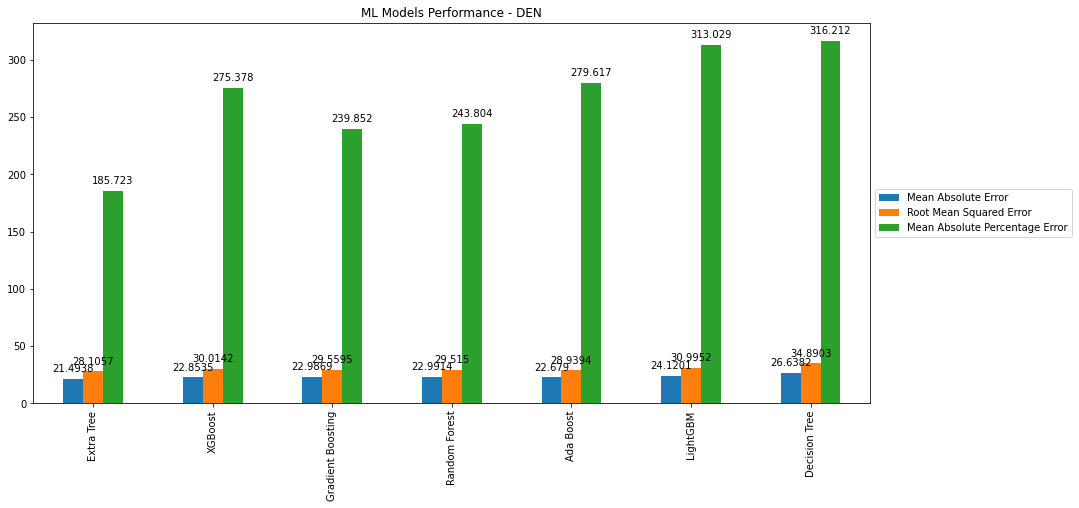

In [16]:
chart = metrics.transpose()
chart.drop(['Mean Squared Error', 'R^2', 'Accuracy'], axis=1, inplace=True)

ax = chart.plot.bar(title="ML Models Performance - " + country, figsize=(15,7))
for container in ax.containers:
    ax.bar_label(container, padding=5)
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))